# Grigoryev Mikhail, Lab 4, J4133c

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'

RNG = 42069

## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

Key steps:

  -Initialize the parameters of the model

  -Learn the parameters for the model by minimizing the cost  

  -Use the learned parameters to make predictions (on the test set)
  
  -Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$ 

In [2]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

In [3]:
print ("sigmoid([0, 2, 10, -10]) = " + str(sigmoid(np.array([0., 2., -2., 100.]))))

sigmoid([0, 2, 10, -10]) = [0.5        0.88079708 0.11920292 1.        ]


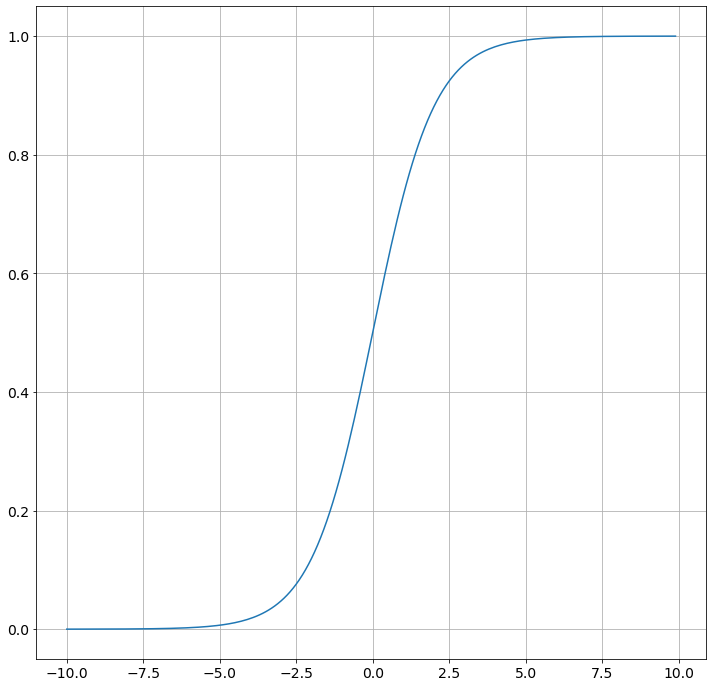

In [4]:
x = np.arange(-10, 10, 0.1)
plt.plot(x, sigmoid(x))
plt.grid()
plt.show()

### Initializing parameters



In [5]:
# initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [6]:
dim = 3
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]]
b = 0.0


### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [7]:
# propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]
    #print('number of objects = ',len(X))
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [8]:
w, b, X, Y = np.array([[1.],[-1.]]), 4., \
             np.array([[1.,5.,-1.],[10.,0.,-3.2]]), \
             np.array([[0,1,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.0027004 ]
 [0.02446984]]
db = [0.00151471]
cost = [0.00295537]


### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [9]:
# default optimizer

def gradient_descent(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    assert Y.shape[0] == 1, f"Shape of Y is wrong: {Y.shape}"
    
    costs = []
    
    for i in range(num_iterations):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [10]:
params, grads, costs = gradient_descent(w, b, X, Y,
                                num_iterations= 5000,
                                learning_rate = 0.005,
                                print_cost = True)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 0: 0.002955
Cost after iteration 100: 0.002683
Cost after iteration 200: 0.002461
Cost after iteration 300: 0.002278
Cost after iteration 400: 0.002124
Cost after iteration 500: 0.001991
Cost after iteration 600: 0.001877
Cost after iteration 700: 0.001777
Cost after iteration 800: 0.001689
Cost after iteration 900: 0.001611
Cost after iteration 1000: 0.001541
Cost after iteration 1100: 0.001478
Cost after iteration 1200: 0.001421
Cost after iteration 1300: 0.001369
Cost after iteration 1400: 0.001321
Cost after iteration 1500: 0.001278
Cost after iteration 1600: 0.001238
Cost after iteration 1700: 0.001200
Cost after iteration 1800: 0.001166
Cost after iteration 1900: 0.001134
Cost after iteration 2000: 0.001104
Cost after iteration 2100: 0.001076
Cost after iteration 2200: 0.001050
Cost after iteration 2300: 0.001025
Cost after iteration 2400: 0.001002
Cost after iteration 2500: 0.000980
Cost after iteration 2600: 0.000959
Cost after iteration 2700: 0.000940
Cost

In [11]:
# stochastic gradient descent

def stochastic_gradient_descent(w, b, X, Y, num_iterations, learning_rate, seed=42069, batch_size=None, print_cost=False):
    """
    This function optimizes w and b by running a stochastic gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    seed -- random seed for stochastic choice of (x, y) pairs
    batch_size -- size of batch for gradient and cost calculations
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    assert Y.shape[0] == 1, f"Shape of Y is wrong: {Y.shape}"
    
    if batch_size == None:
        batch_size = int(Y.shape[1] / 10)
    
    costs = []
    
    for i in range(num_iterations):
        
        # Stochasticity - random choice of (x, y) for propagation
        
        idx = np.random.choice(int(Y.shape[1]), batch_size)
        xs, ys = X[:, idx], Y[:, idx]
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,xs,ys)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w -=learning_rate*dw
        b -=learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [12]:
params, grads, costs = stochastic_gradient_descent(w, b, X, Y,
                                                   num_iterations= 5000,
                                                   learning_rate = 0.005,
                                                   seed=RNG,
                                                   batch_size=1,
                                                   print_cost = True)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 0: 0.001023
Cost after iteration 100: 0.001017
Cost after iteration 200: 0.001011
Cost after iteration 300: 0.000787
Cost after iteration 400: 0.000139
Cost after iteration 500: 0.000139
Cost after iteration 600: 0.000139
Cost after iteration 700: 0.000981
Cost after iteration 800: 0.000975
Cost after iteration 900: 0.000706
Cost after iteration 1000: 0.000964
Cost after iteration 1100: 0.000139
Cost after iteration 1200: 0.000140
Cost after iteration 1300: 0.000948
Cost after iteration 1400: 0.000943
Cost after iteration 1500: 0.000940
Cost after iteration 1600: 0.000935
Cost after iteration 1700: 0.000140
Cost after iteration 1800: 0.000925
Cost after iteration 1900: 0.000140
Cost after iteration 2000: 0.000140
Cost after iteration 2100: 0.000140
Cost after iteration 2200: 0.000577
Cost after iteration 2300: 0.000901
Cost after iteration 2400: 0.000898
Cost after iteration 2500: 0.000141
Cost after iteration 2600: 0.000141
Cost after iteration 2700: 0.000141
Cost

In [13]:
# ADAM

def adam(w, b, X, Y, num_iterations, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=False):
    """
    This function optimizes w and b by running ADAM optimization algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    beta1 -- first parameter of ADAM
    beta2 -- second parameter of ADAM
    epsilon -- tolerance for ADAM
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    assert Y.shape[0] == 1, f"Shape of Y is wrong: {Y.shape}"
    
    costs = []
    
    for i in range(1, num_iterations+1):
                
        # Cost and gradient calculation 
        grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Moments
        m_dw, v_dw = 0.0, 0.0
        m_db, v_db = 0.0, 0.0
        
        m_dw = beta1 * m_dw + (1 - beta1) * dw
        m_db = beta1 * m_db + (1 - beta1) * db
        v_dw = beta2 * v_dw + (1 - beta2) * (dw**2)
        v_db = beta2 * v_db + (1 - beta2) * (db**2) # squared for second-order moment
        
        m_dw_corr = m_dw / (1 - beta1**i)
        m_db_corr = m_db / (1 - beta1**i)
        v_dw_corr = v_dw / (1 - beta2**i)
        v_db_corr = v_db / (1 - beta2**i)
        
        # Update rule
        w = w - learning_rate * (m_dw_corr / (np.sqrt(v_dw_corr) + epsilon))
        b = b - learning_rate * (m_db_corr / (np.sqrt(v_db_corr) + epsilon))
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
params, grads, costs = adam(w, b, X, Y,
                            num_iterations= 5000,
                            learning_rate = 0.005,
                            print_cost = True)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 100: 0.000093
Cost after iteration 200: 0.000010
Cost after iteration 300: 0.000001
Cost after iteration 400: 0.000000
Cost after iteration 500: 0.000000
Cost after iteration 600: 0.000000
Cost after iteration 700: 0.000000
Cost after iteration 800: 0.000000
Cost after iteration 900: 0.000000
Cost after iteration 1000: 0.000000
Cost after iteration 1100: 0.000000
Cost after iteration 1200: 0.000000
Cost after iteration 1300: 0.000000
Cost after iteration 1400: 0.000000
Cost after iteration 1500: 0.000000
Cost after iteration 1600: 0.000000
Cost after iteration 1700: 0.000000
Cost after iteration 1800: 0.000000
Cost after iteration 1900: 0.000000
Cost after iteration 2000: 0.000000
Cost after iteration 2100: 0.000000
Cost after iteration 2200: 0.000000
Cost after iteration 2300: 0.000000
Cost after iteration 2400: 0.000000
Cost after iteration 2500: 0.000000
Cost after iteration 2600: 0.000000
Cost after iteration 2700: 0.000000
Cost after iteration 2800: 0.000000
C

Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`. 

In [15]:
# predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction

In [16]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]



Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model

- Y_prediction_test for the predictions on the test set
- Y_prediction_train for the predictions on the train set
- w, costs, grads for the outputs of optimize()

In [17]:
# model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, optimizer=gradient_descent, print_cost = False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimizer(w, b, X_train, Y_train, num_iterations, learning_rate=learning_rate, print_cost=print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/


Gather data

In [18]:
df = pd.read_csv("./bioresponse.csv", header=0, sep=',')
Y = np.array(df['Activity'].values)
X = np.array(df.iloc[:, 1:])

print(f"X shape:\t{X.shape}\nY shape:\t{Y.shape}")

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.25, random_state = RNG)

X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = Y_train.reshape((1, -1)), Y_test.reshape((1, -1))

print(f"X_train shape:\t{X_train.shape}\nY_train shape:\t{Y_train.shape}")
print(f"X_test shape:\t{X_test.shape}\nY_test shape:\t{Y_test.shape}")

X shape:	(3751, 1776)
Y shape:	(3751,)
X_train shape:	(1776, 2813)
Y_train shape:	(1, 2813)
X_test shape:	(1776, 938)
Y_test shape:	(1, 938)


Training with different params

In [19]:
alpha_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

In [20]:
model_gd = []

for alpha in alpha_list:
    print(f"ALPHA = {alpha}")
    pc = (alpha == 0.001)
    cur = model(X_train, Y_train, X_test, Y_test,
          num_iterations = 2000, learning_rate = alpha, optimizer=gradient_descent,
          print_cost = pc)
    model_gd.append(cur)
    print("\n")

ALPHA = 0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.679434
Cost after iteration 200: 0.672089
Cost after iteration 300: 0.665612
Cost after iteration 400: 0.659628
Cost after iteration 500: 0.654058
Cost after iteration 600: 0.648851
Cost after iteration 700: 0.643966
Cost after iteration 800: 0.639370
Cost after iteration 900: 0.635034
Cost after iteration 1000: 0.630934
Cost after iteration 1100: 0.627047
Cost after iteration 1200: 0.623356
Cost after iteration 1300: 0.619845
Cost after iteration 1400: 0.616498
Cost after iteration 1500: 0.613302
Cost after iteration 1600: 0.610247
Cost after iteration 1700: 0.607320
Cost after iteration 1800: 0.604514
Cost after iteration 1900: 0.601820
train accuracy: 72.73373622467116 %
test accuracy: 69.40298507462687 %


ALPHA = 0.002
train accuracy: 74.65339495200854 %
test accuracy: 72.17484008528784 %


ALPHA = 0.005
train accuracy: 77.03519374333452 %
test accuracy: 74.09381663113007 %


ALPHA = 0.01
train accuracy: 79

In [21]:
model_sgd = []

for alpha in alpha_list:
    print(f"ALPHA = {alpha}")
    pc = (alpha == 0.001)
    cur = model(X_train, Y_train, X_test, Y_test,
                num_iterations = 2000, learning_rate = alpha,
                optimizer=stochastic_gradient_descent,
                print_cost = pc)
    model_sgd.append(cur)
    print("\n")

# Computation took WAY less time

ALPHA = 0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.681583
Cost after iteration 200: 0.674553
Cost after iteration 300: 0.654198
Cost after iteration 400: 0.664828
Cost after iteration 500: 0.657003
Cost after iteration 600: 0.632368
Cost after iteration 700: 0.652663
Cost after iteration 800: 0.640945
Cost after iteration 900: 0.635700
Cost after iteration 1000: 0.643726
Cost after iteration 1100: 0.618331
Cost after iteration 1200: 0.636815
Cost after iteration 1300: 0.603279
Cost after iteration 1400: 0.608396
Cost after iteration 1500: 0.602047
Cost after iteration 1600: 0.597618
Cost after iteration 1700: 0.624312
Cost after iteration 1800: 0.603284
Cost after iteration 1900: 0.612178
train accuracy: 72.9825808745112 %
test accuracy: 69.5095948827292 %


ALPHA = 0.002
train accuracy: 74.68894418769996 %
test accuracy: 71.74840085287846 %


ALPHA = 0.005
train accuracy: 77.03519374333452 %
test accuracy: 73.88059701492537 %


ALPHA = 0.01
train accuracy: 79.2

In [22]:
model_adam = []

for alpha in alpha_list:
    print(f"ALPHA = {alpha}")
    pc = (alpha == 0.001)
    cur = model(X_train, Y_train, X_test, Y_test,
                num_iterations = 2000, learning_rate = alpha,
                optimizer=adam,
                print_cost = pc)
    model_adam.append(cur)
    print("\n")

# ADAM results are more accurate

ALPHA = 0.001
Cost after iteration 100: 0.515959
Cost after iteration 200: 0.466251
Cost after iteration 300: 0.442936
Cost after iteration 400: 0.428337
Cost after iteration 500: 0.420549
Cost after iteration 600: 0.415623
Cost after iteration 700: 0.412045
Cost after iteration 800: 0.409143
Cost after iteration 900: 0.406854
Cost after iteration 1000: 0.405081
Cost after iteration 1100: 0.403630
Cost after iteration 1200: 0.402383
Cost after iteration 1300: 0.401292
Cost after iteration 1400: 0.400332
Cost after iteration 1500: 0.399442
Cost after iteration 1600: 0.398595
Cost after iteration 1700: 0.397854
Cost after iteration 1800: 0.397180
Cost after iteration 1900: 0.396600
Cost after iteration 2000: 0.396083
train accuracy: 83.50515463917526 %
test accuracy: 76.33262260127933 %


ALPHA = 0.002
train accuracy: 79.27479559189477 %
test accuracy: 75.69296375266525 %


ALPHA = 0.005
train accuracy: 63.45538570920725 %
test accuracy: 62.79317697228145 %


ALPHA = 0.01
train accuracy:

/tmp/ipykernel_31048/2989978550.py:24: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
/tmp/ipykernel_31048/2989978550.py:24: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost


train accuracy: 55.74120156416637 %
test accuracy: 55.650319829424305 %


ALPHA = 0.05
train accuracy: 55.670103092783506 %
test accuracy: 55.543710021321964 %




## Learning curve plots comparison of optimizers

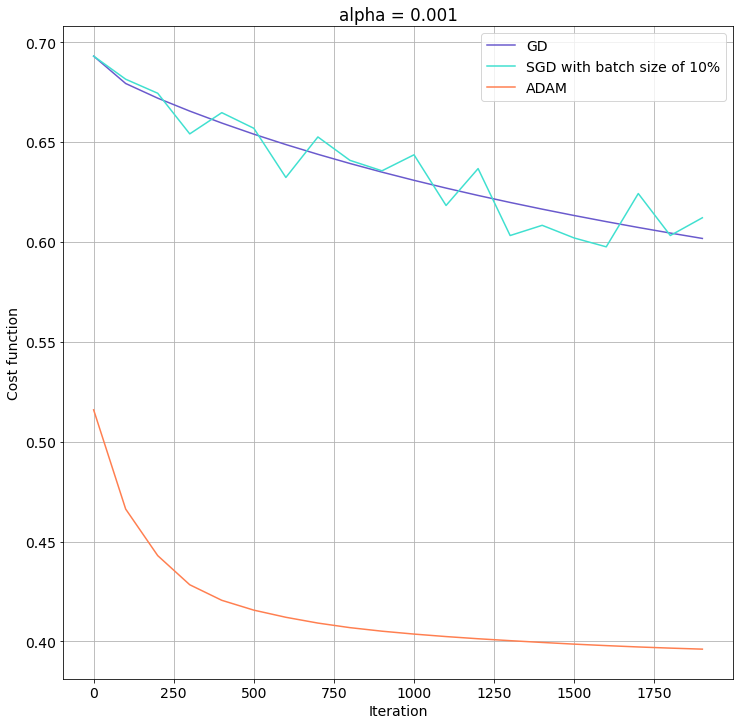

In [23]:
iters = [100*num for num, item in enumerate(model_gd[0]['costs'])]
index = 0

plt.grid()
plt.plot(iters, model_gd[index]['costs'], label='GD', color='slateblue')
plt.plot(iters, model_sgd[index]['costs'], label='SGD with batch size of 10%', color='turquoise')
plt.plot(iters, model_adam[index]['costs'], label='ADAM', color='coral')

plt.title(f'alpha = {alpha_list[index]}')

plt.xlabel('Iteration')
plt.ylabel('Cost function')

plt.legend()

## Learning curve plots by alpha values

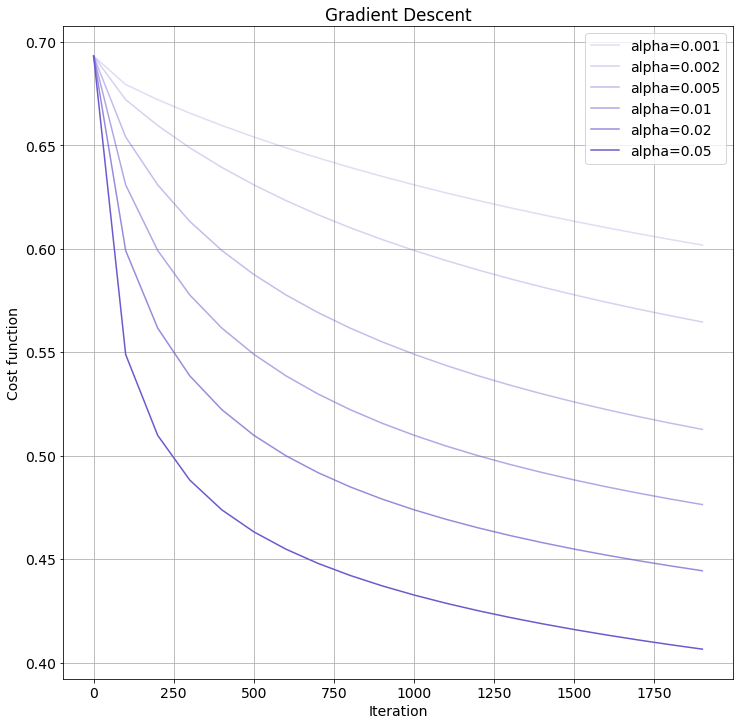

In [24]:
plt.grid()
for index in range(len(alpha_list)):
    plt.plot(iters, model_gd[index]['costs'], 
             label=f'alpha={alpha_list[index]}', 
             color='slateblue', 
             alpha=(alpha_list[index]/max(alpha_list))**(0.4))

plt.title('Gradient Descent')

plt.xlabel('Iteration')
plt.ylabel('Cost function')

plt.legend()

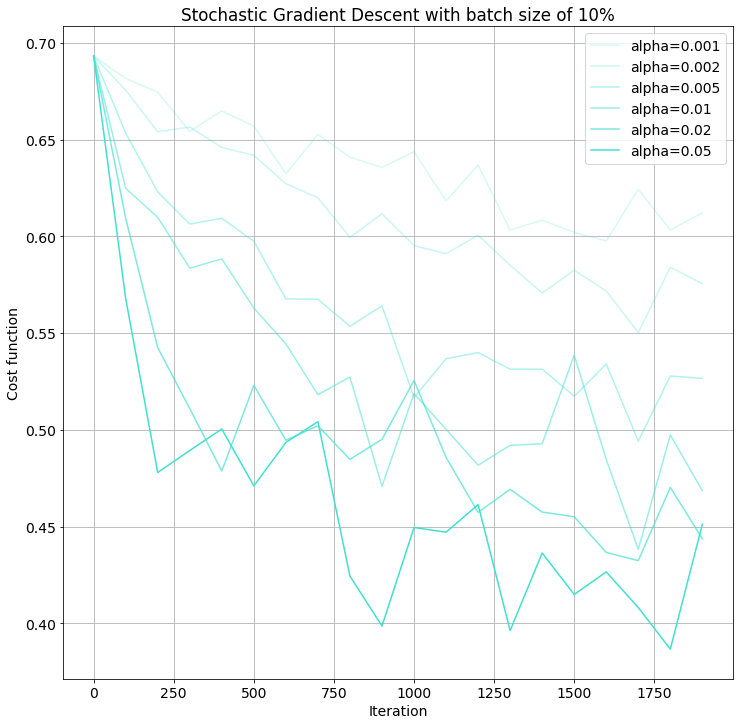

In [25]:
plt.grid()
for index in range(len(alpha_list)):
    plt.plot(iters, model_sgd[index]['costs'], 
             label=f'alpha={alpha_list[index]}', 
             color='turquoise', 
             alpha=(alpha_list[index]/max(alpha_list))**(0.4))

plt.title('Stochastic Gradient Descent with batch size of 10%')

plt.xlabel('Iteration')
plt.ylabel('Cost function')

plt.legend()

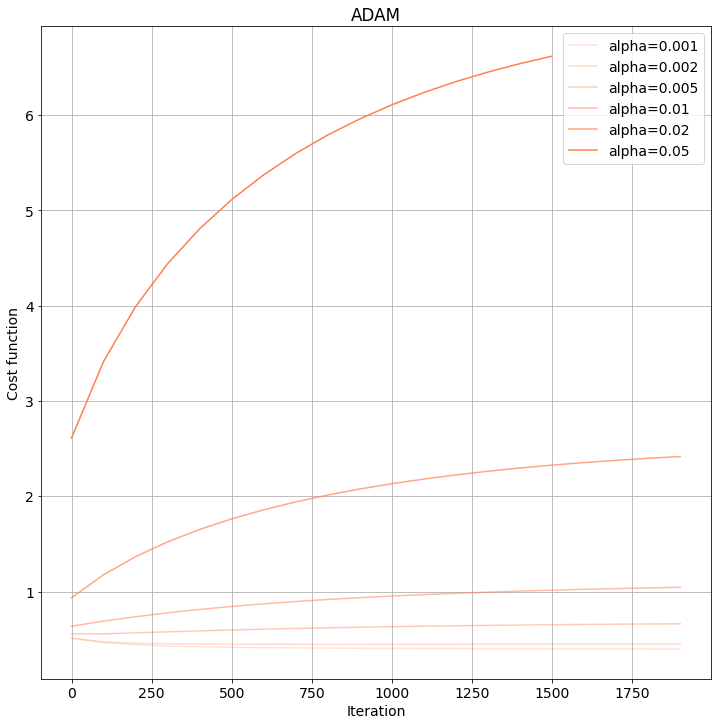

In [26]:
plt.grid()
for index in range(len(alpha_list)):
    plt.plot(iters, model_adam[index]['costs'], 
             label=f'alpha={alpha_list[index]}', 
             color='coral', 
             alpha=(alpha_list[index]/max(alpha_list))**(0.4))

plt.title('ADAM')

plt.xlabel('Iteration')
plt.ylabel('Cost function')

plt.legend()

## Notes on accuracy, optimizers and learning rates

In [27]:
def test_accuracy(Y_prediction_test, Y_test):
    return 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100

In [28]:
model_list = [model_gd, model_sgd, model_adam]

acc = np.zeros((3, len(alpha_list)))
for i in range(acc.shape[0]):
    for j in range(acc.shape[1]):
        acc[i,j] = test_accuracy(model_list[i][j]["Y_prediction_test"], Y_test)

acc_df = pd.DataFrame(acc, columns=alpha_list, index=['GD', 'SGD (10%)', 'ADAM'])
acc_df.head()

,0.001,0.002,0.005,0.010,0.020,0.050
GD,69.402985,72.174840,74.093817,74.733475,75.373134,75.906183
SGD (10%),69.509595,71.748401,73.880597,74.520256,75.373134,75.586354
ADAM,76.332623,75.692964,62.793177,45.735608,55.650320,55.543710


Conclusions:
- according to the first plot, ADAM is the best performing optimizer of the three;
- SGD has the advantage of fast computations (batch size was chosen as 10% of the data);
- GD and SGD benefit from increase of learning rate from 0.001 to 0.05, while ADAM suffers from it;
- thus even better models can be built with GD and SGD with higher alpha values and ADAM with lower alpha values.